In [1]:
import jieba
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import io,sparse
import json
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.decomposition import PCA

In [2]:
def logtime(func):
    """
    函数目的：测量函数运行时间 
    Parameter:
        func - 被测量的函数
    Return:
        wrapper - 被装饰之后的函数
    """
    def wrapper(*args,**kwargs):
        start = time.time()
        result = func(*args,**kwargs)
        end = time.time()
        print("完成函数{name}, 运行时间 {totaltime:.3f}s".format(name=func.__name__,totaltime=end-start))
        start = time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(start))
        end = time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(end))
        print("开始时间 : %s \n结束时间 : %s "%(start,end))
        return result
    return wrapper

In [3]:
def load_data_from_file(content_path,label_path):
    content = io.mmread(content_path)
    with open(label_path, 'r') as f:
        label = json.load(f)
    return content,label

In [4]:
def split_data(content,label):
    train_content,test_content,train_label,test_label = train_test_split(content,label,test_size=0.2)
    return train_content,test_content,train_label,test_label

In [5]:
@logtime
def dimensionality_reduction(content):
        n_components = 1000
        pca = PCA(n_components=n_components, svd_solver='auto')
        pca.fit(content)
        content = sparse.csr_matrix(pca.transform(content))
        return content

In [6]:
@logtime
def clf_train(clf,train_content,train_label):
    return clf.fit(train_content.toarray(),train_label)

In [7]:
def train_svm(train_content,train_label):
    """
    函数说明：训练SVM分类器
    Parameter:
        train_content - 训练数据
        train_label - 训练标签
    Return:
        classifier.fit(vector,label) - 训练好的分类器
    Modify:
        2017-12-22
    """
    kernals = ["linear","rbf"]
    clfs = []
    for kernel in kernals:
       
        clf = svm.SVC(kernel=kernel)
        clf = clf_train(clf,train_content,train_label)
        clfs.append(clf)
    return clfs

In [8]:
def train_bayes(train_content,train_label):
    """
    函数说明：训练贝叶斯分类器
    Parameter:
        train_content - 训练数据
        train_label - 训练标签
    Return:
        classifier.fit(vector,label) - 训练好的分类器
    Modify:
        2017-12-22
    
    """
    bayes = [ GaussianNB(),MultinomialNB(),BernoulliNB()]
    clfs = []
    for baye in bayes:
        clf = clf_train(baye,train_content,train_label)
        clfs.append(clf)
    return clfs

In [9]:
@logtime
def clf_pred(clf,test_content,test_label):
    pred=clf.predict(test_content.toarray())
    score = elevate_result(pred,test_label)
    return score

In [10]:
def elevate_result(label,pred):
    """
    函数说明: 对分类器预测的结果进行评估，包括accurancy,precision,recall,F-score
    Parameter:
        label - 真实值
        pred - 预测值
    Return:
        None
    Modify:
        2017-12-22
    """
    con_mat = metrics.confusion_matrix(label,pred)
    TP = con_mat[1,1]
    TN = con_mat[0,0]
    FP = con_mat[0,1]
    FN = con_mat[1,0]
    
    accurancy = (TP+TN)/(TP+TN+FN+FP)
    precison = TP/(TP+FP)
    recall = TP/(TP+FN)
    beta = 1
    F_score = (1+pow(beta,2))*precison*recall/(pow(beta,2)*precison+recall)
    
    print("TP:",TP)
    print("TN:",TN)
    print("FP:",FP)
    print("FN:",FN)
    print("accurancy: %s \nprecison: %s \nrecall: %s \nF-score: %s" % (accurancy,precison,recall,F_score))
    
    return [accurancy,precison,recall,F_score]


In [11]:
def plot_result(scores):
    scorename = ["accurancy","precision","recall","F_score"]
    labels = ["SVM-linear","SVM-rbf","GaussianNB","MultinomialNB","BernoulliNB"]
#     labels = ["SVM-linear","SVM-rbf"]
    fig,ax = plt.subplots(figsize=(16,10))
    
    x = np.arange(len(scorename))
    total_width, n = 0.8,5     # 有多少个类型，只需更改n即可
    width = total_width / n
    x = x - (total_width - width) / 2
    
    for index,score in enumerate(scores):
        ax.bar(x+index*width,score,alpha=0.8,label=labels[index],width=width)
        
    ax.set_ylim(ymax=1.2)     
    ax.set_yticks(np.arange(0,1.2,0.2))
    ax.set_yticklabels(np.arange(0,1.2,0.2),fontsize=15)
    ax.set_xlim(xmax=len(scorename)+0.5)
    ax.set_xticks(range(len(scorename)))
    ax.set_xticklabels(scorename,fontsize=15)
    plt.legend(loc='lower right',fontsize=15)
    plt.savefig("result.jpg")
    plt.show()

In [12]:
def main():
    content_path = "../data/content_vector.mtx"
    label_path = "../data/label_vector.json"
    
    content,label=load_data_from_file(content_path,label_path)
#     content = dimensionality_reduction(content.todense())
    train_content,test_content,train_label,test_label = split_data(content,label)
    
    scores = []
    
    svms = train_svm(train_content,train_label)
    for clf in svms:   
        score = clf_pred(clf,test_content,test_label)
        scores.append(score)
        
    bayes = train_bayes(train_content,train_label)
    for clf in bayes:   
        score = clf_pred(clf,test_content,test_label)
        scores.append(score)
    plot_result(scores)

完成函数clf_train, 运行时间 73.328s
开始时间 : 2017-12-23 00:07:24 
结束时间 : 2017-12-23 00:08:37 
完成函数clf_train, 运行时间 163.546s
开始时间 : 2017-12-23 00:08:37 
结束时间 : 2017-12-23 00:11:21 
TP: 170
TN: 1820
FP: 10
FN: 0
accurancy: 0.995 
precison: 0.944444444444 
recall: 1.0 
F-score: 0.971428571429
完成函数clf_pred, 运行时间 16.966s
开始时间 : 2017-12-23 00:11:21 
结束时间 : 2017-12-23 00:11:38 
TP: 118
TN: 1820
FP: 62
FN: 0
accurancy: 0.969 
precison: 0.655555555556 
recall: 1.0 
F-score: 0.791946308725
完成函数clf_pred, 运行时间 38.323s
开始时间 : 2017-12-23 00:11:38 
结束时间 : 2017-12-23 00:12:16 
完成函数clf_train, 运行时间 1.600s
开始时间 : 2017-12-23 00:12:16 
结束时间 : 2017-12-23 00:12:18 
完成函数clf_train, 运行时间 0.557s
开始时间 : 2017-12-23 00:12:18 
结束时间 : 2017-12-23 00:12:18 
完成函数clf_train, 运行时间 1.228s
开始时间 : 2017-12-23 00:12:18 
结束时间 : 2017-12-23 00:12:20 
TP: 176
TN: 1682
FP: 4
FN: 138
accurancy: 0.929 
precison: 0.977777777778 
recall: 0.56050955414 
F-score: 0.712550607287
完成函数clf_pred, 运行时间 0.524s
开始时间 : 2017-12-23 00:12:20 
结束时间 : 2017-12-23 

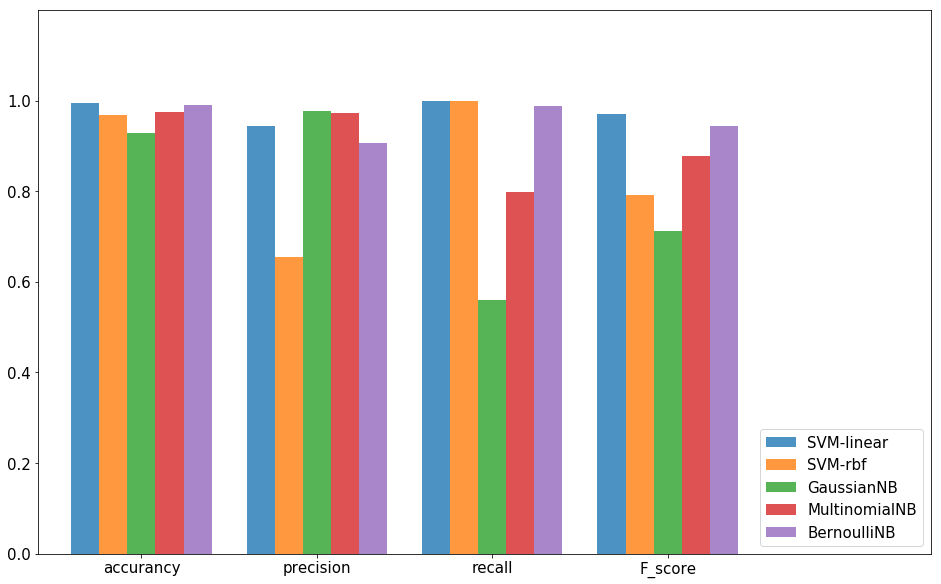

In [13]:
if __name__ == "__main__":
#     pass
    main()